In [41]:
import gymnasium as gym
import numpy as np
import d3rlpy
import pickle

import matplotlib.pyplot as plt
from env.atari.represented_atari_game import GymCompatWrapper2
from online_main import OneHotWrapper

hyperparams = {
        "env": "FrozenLake-v1", #"CartPole-v0", # "Acrobot-v0", "MountainCar-v0", "FrozenLake-v1", "CliffWalking-v0", "Taxi-v3", "RepresentedPong-v0"
        "seed": 42069,
        "n_episodes": 100,#5000,
        "max_episode_len": 200, # Around 10h per 100k steps in Leviathan server
        "eps": 0.1,  # epsilon for exploration
        "n_exp": 5,
        "n_pretrain_eps": 30,
        "n_online_eps": 120, #10-290 for mountainCar, 30-120 for CartPole
        "gpu": True, # True if use GPU to train with d3rlpy
        "buffer_size": 100000, #Test with 100k, 200k, 500k. 1M might be too much
        "data_path": None,#'data/CartPole_Qwen2.5-7B-Instruct_Neps_10_20250406040150.pkl',
        "model_path": None,#'d3rlpy_loss/DoubleDQN_online_20250331153346/model_600000.d3',
        "batch_size":256, #Test smaller batch size: 32, 64. May be noisier
        "learning_rate":5e-5,
        "gamma":0.99,
        "target_update_interval":1000 #Test with 1k, 2k, 5k
    }

if "Represented" in hyperparams["env"]:
    env = GymCompatWrapper2(gym.make(hyperparams["env"]))
    eval_env = GymCompatWrapper2(gym.make(hyperparams["env"]))
elif isinstance(gym.make(hyperparams["env"]).observation_space, gym.spaces.Discrete):
    env = OneHotWrapper(gym.make(hyperparams["env"]))
    eval_env = OneHotWrapper(gym.make(hyperparams["env"]))
else:
    env = gym.make(hyperparams["env"])
    eval_env = gym.make(hyperparams["env"])

# fix seed
d3rlpy.seed(hyperparams["seed"])
d3rlpy.envs.seed_env(env, hyperparams["seed"])
d3rlpy.envs.seed_env(eval_env, hyperparams["seed"])

### Static/pretrain data

In [42]:
with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250412075104.pkl", 'rb') as file: #FrozenLake
# with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250411000858.pkl", 'rb') as file: #FrozenLakeBug
# with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250410211529.pkl", 'rb') as file: #CartPole
# with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-7B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250409023954E.pkl", 'rb') as file: #CartPoleE
    Qwen_7B_dataset = pickle.load(file)
with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-32B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250412120230.pkl", 'rb') as file: #FrozenLake
# with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-32B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250411030422.pkl", 'rb') as file: #FrozenLakeBug
# with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-32B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250412032827.pkl", 'rb') as file: #CartPole
# with open(f"data/{hyperparams['env'].split('-')[0]}_Qwen2.5-32B-Instruct_Neps_{hyperparams['n_pretrain_eps']}_20250409124533E.pkl", 'rb') as file: #CartPoleE
    Qwen_32B_dataset = pickle.load(file)

Qwen_32B_rewards = []
for i in range(hyperparams["n_pretrain_eps"]):
    Qwen_32B_rewards.append(Qwen_32B_dataset.episodes[i].compute_return())
Qwen_7B_rewards = []
for i in range(hyperparams["n_pretrain_eps"]):
    Qwen_7B_rewards.append(Qwen_7B_dataset.episodes[i].compute_return())

Qwen_7B = Qwen_7B_rewards + hyperparams["n_online_eps"] * [np.mean(Qwen_7B_rewards)]
Qwen_32B = Qwen_32B_rewards + hyperparams["n_online_eps"] * [np.mean(Qwen_32B_rewards)]

print("Qwen_32B: ", np.mean(Qwen_7B_rewards))
print("Qwen_7B: ", np.mean(Qwen_32B_rewards))

Qwen_32B:  0.0
Qwen_7B:  0.0


### Generate and evaluate random baseline

In [43]:
# Evaluate the random policy manually
random_rewards = []
for _ in range(hyperparams["n_pretrain_eps"]):
	obs, _ = env.reset()
	done = False
	total_reward = 0
	count = 0
	while not done:
		action = env.action_space.sample()
		obs, reward, done, _, _ = env.step(action)
		total_reward += reward
		count += 1
		if count >= hyperparams["max_episode_len"]:
			break
	random_rewards.append(total_reward)

mean_random = np.ones(hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]) * np.mean(random_rewards)
# Print the average reward of the random policy
print(f"Average reward for random policy: {mean_random[0]}")

Average reward for random policy: 0.0


### Fine-tune and Online data

In [44]:
def cache_to_arrays(cache, mean_random, Qwen_7B, Qwen_32B):
    online_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
    finetune_7b_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
    finetune_32b_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
    pretrain_7b_1000_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
    pretrain_32b_1000_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
    pretrain_7b_3000_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))
    pretrain_32b_3000_returns = np.zeros((hyperparams["n_exp"], hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"]))

    for i in range(hyperparams["n_exp"]):
        online_returns[i] = cache[f"online_{i}"]
        for j in range(hyperparams["n_online_eps"]):
            finetune_7b_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"finetune_7b_{i}"][j]
            finetune_32b_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"finetune_32b_{i}"][j]
            pretrain_7b_1000_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"pretrain_7b_1000_{i}"][j]
            pretrain_32b_1000_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"pretrain_32b_1000_{i}"][j]
            pretrain_7b_3000_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"pretrain_7b_3000_{i}"][j]
            pretrain_32b_3000_returns[i][hyperparams["n_pretrain_eps"]+j] = cache[f"pretrain_32b_3000_{i}"][j]

    x = range(hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"])

    mean_finetune_32b = np.mean(finetune_32b_returns, axis = 0)
    std_finetune_32b = np.std(finetune_32b_returns, axis = 0)
    mean_finetune_7b = np.mean(finetune_7b_returns, axis = 0)
    std_finetune_7b = np.std(finetune_7b_returns, axis = 0)
    mean_onl = np.mean(online_returns, axis = 0)
    std_onl = np.std(online_returns, axis = 0)
    mean_pretrain_32b_1000 = np.mean(pretrain_32b_1000_returns, axis = 0)
    std_pretrain_32b_1000 = np.std(pretrain_32b_1000_returns, axis = 0)
    mean_pretrain_7b_1000 = np.mean(pretrain_7b_1000_returns, axis = 0)
    std_pretrain_7b_1000 = np.std(pretrain_7b_1000_returns, axis = 0)
    mean_pretrain_32b_3000 = np.mean(pretrain_32b_3000_returns, axis = 0)
    std_pretrain_32b_3000 = np.std(pretrain_32b_3000_returns, axis = 0)
    mean_pretrain_7b_3000 = np.mean(pretrain_7b_3000_returns, axis = 0)
    std_pretrain_7b_3000 = np.std(pretrain_7b_3000_returns, axis = 0)

    mean_finetune_7b[:hyperparams["n_pretrain_eps"]] = Qwen_7B[:hyperparams["n_pretrain_eps"]]
    mean_finetune_32b[:hyperparams["n_pretrain_eps"]] = Qwen_32B[:hyperparams["n_pretrain_eps"]]
    mean_pretrain_32b_1000[:hyperparams["n_pretrain_eps"]] = Qwen_32B[:hyperparams["n_pretrain_eps"]]
    mean_pretrain_7b_1000[:hyperparams["n_pretrain_eps"]] = Qwen_7B[:hyperparams["n_pretrain_eps"]]
    mean_pretrain_32b_3000[:hyperparams["n_pretrain_eps"]] = Qwen_32B[:hyperparams["n_pretrain_eps"]]
    mean_pretrain_7b_3000[:hyperparams["n_pretrain_eps"]] = Qwen_7B[:hyperparams["n_pretrain_eps"]]

    out_dict = {
        "mean_finetune_32b": mean_finetune_32b,
        "std_finetune_32b": std_finetune_32b,
        "mean_finetune_7b": mean_finetune_7b,
        "std_finetune_7b": std_finetune_7b,
        "mean_onl": mean_onl,
        "std_onl": std_onl,
        "mean_pretrain_32b_1000": mean_pretrain_32b_1000,
        "std_pretrain_32b_1000": std_pretrain_32b_1000,
        "mean_pretrain_7b_1000": mean_pretrain_7b_1000,
        "std_pretrain_7b_1000": std_pretrain_7b_1000,
        "mean_pretrain_32b_3000": mean_pretrain_32b_3000,
        "std_pretrain_32b_3000": std_pretrain_32b_3000,
        "mean_pretrain_7b_3000": mean_pretrain_7b_3000,
        "std_pretrain_7b_3000": std_pretrain_7b_3000
    }

    plt.figure(figsize=(12, 6))
    plt.plot(mean_onl, label='On-policy')
    plt.fill_between(x, mean_onl-std_onl/np.sqrt(hyperparams["n_exp"]), mean_onl+std_onl/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    plt.plot(mean_finetune_32b, label='Mix Qwen 32B')
    plt.fill_between(x, mean_finetune_32b-std_finetune_32b/np.sqrt(hyperparams["n_exp"]), mean_finetune_32b+std_finetune_32b/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    plt.plot(mean_finetune_7b, label='Mix Qwen 7B')
    plt.fill_between(x, mean_finetune_7b-std_finetune_7b/np.sqrt(hyperparams["n_exp"]), mean_finetune_7b+std_finetune_7b/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    plt.plot(mean_pretrain_32b_1000, label='Pretrain Qwen 32B 1000 steps')
    plt.fill_between(x, mean_pretrain_32b_1000-std_pretrain_32b_1000/np.sqrt(hyperparams["n_exp"]), mean_pretrain_32b_1000+std_pretrain_32b_1000/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    plt.plot(mean_pretrain_7b_1000, label='Pretrain Qwen 7B 1000 steps')
    plt.fill_between(x, mean_pretrain_7b_1000-std_pretrain_7b_1000/np.sqrt(hyperparams["n_exp"]), mean_pretrain_7b_1000 +std_pretrain_7b_1000/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    plt.plot(mean_pretrain_32b_3000, label='Pretrain Qwen 32B 3000 steps')
    plt.fill_between(x, mean_pretrain_32b_3000-std_pretrain_32b_3000/np.sqrt(hyperparams["n_exp"]), mean_pretrain_32b_3000+std_pretrain_32b_3000/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    plt.plot(mean_pretrain_7b_3000, label='Pretrain Qwen 7B 3000 steps')
    plt.fill_between(x, mean_pretrain_7b_3000-std_pretrain_7b_3000/np.sqrt(hyperparams["n_exp"]), mean_pretrain_7b_3000 +std_pretrain_7b_3000/np.sqrt(hyperparams["n_exp"]), alpha=0.3)

    plt.plot(Qwen_7B, label='Qwen_7B', linestyle=':')
    plt.plot(Qwen_32B, label='Qwen_32B', linestyle=':')
    plt.plot(mean_random, label='Random', linestyle=':')

    # Customize the plot
    plt.title(f'Sum episode reward for Double-DQN with {hyperparams["n_pretrain_eps"]} eps data collection and {hyperparams["n_online_eps"]} eps On-policy learning (#seed={hyperparams["n_exp"]}) with std error.')
    plt.xlabel('# of episodes')
    plt.ylabel('Eps reward')
    # plt.legend()
    # plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    # plt.xticks(np.arange(0, 101, 10))
    # Show the plot
    plt.show()
    return out_dict

# Plot

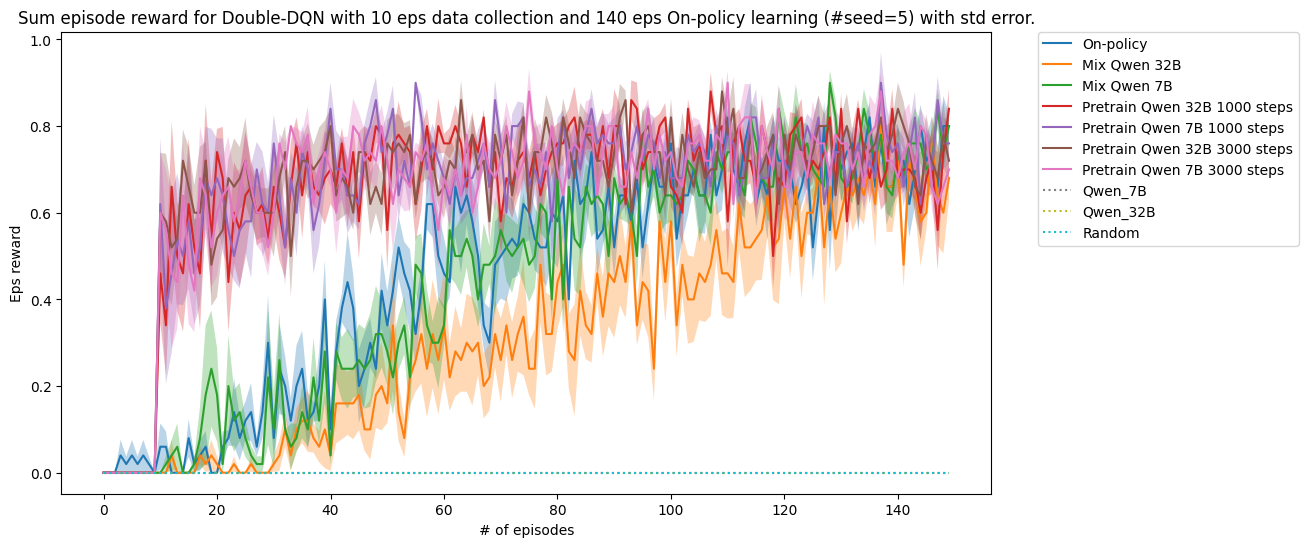

In [45]:
hyperparams["n_pretrain_eps"]=10
hyperparams["n_online_eps"]=150-hyperparams["n_pretrain_eps"]
with open(f"data/cache_{hyperparams['env'].split('-')[0]}_Neps_{hyperparams['n_pretrain_eps']}.pkl", 'rb') as file: #CartPoleE
# with open(f"data/cache_{hyperparams['env'].split('-')[0]}_Neps_{hyperparams['n_pretrain_eps']}_withEps.pkl", 'rb') as file: #CartPoleE
    cache10 = pickle.load(file)
out_dict10 = cache_to_arrays(cache10, mean_random, Qwen_7B, Qwen_32B)

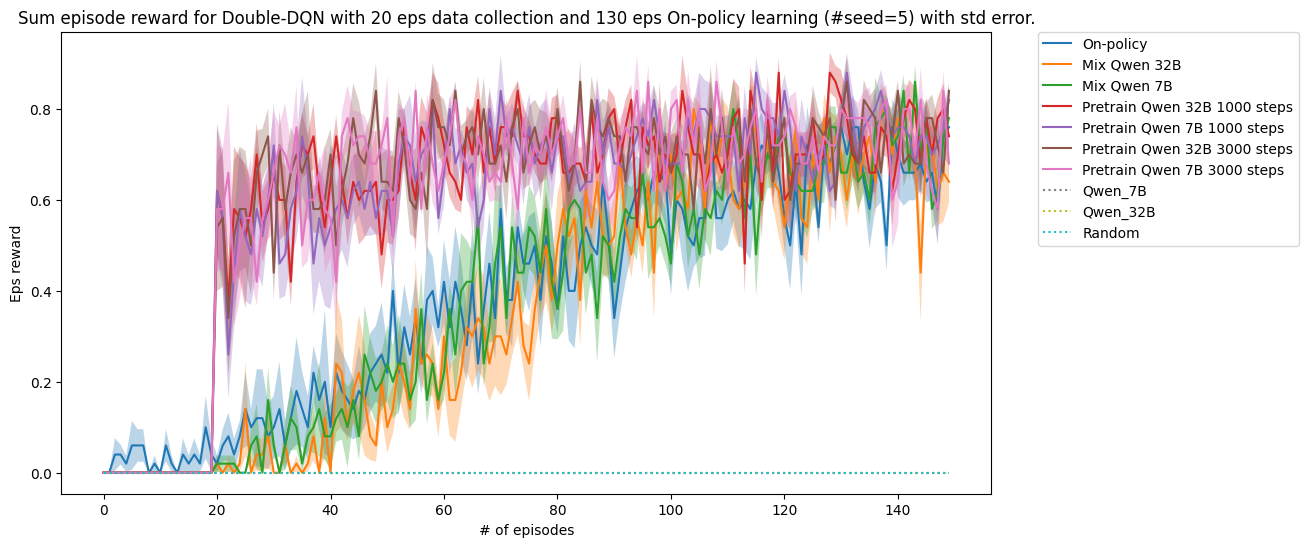

In [46]:
hyperparams["n_pretrain_eps"]=20
hyperparams["n_online_eps"]=150-hyperparams["n_pretrain_eps"]
with open(f"data/cache_{hyperparams['env'].split('-')[0]}_Neps_{hyperparams['n_pretrain_eps']}.pkl", 'rb') as file: #CartPoleE
# with open(f"data/cache_{hyperparams['env'].split('-')[0]}_Neps_{hyperparams['n_pretrain_eps']}_withEps.pkl", 'rb') as file: #CartPoleE
    cache20 = pickle.load(file)
out_dict20 = cache_to_arrays(cache20, mean_random, Qwen_7B, Qwen_32B)

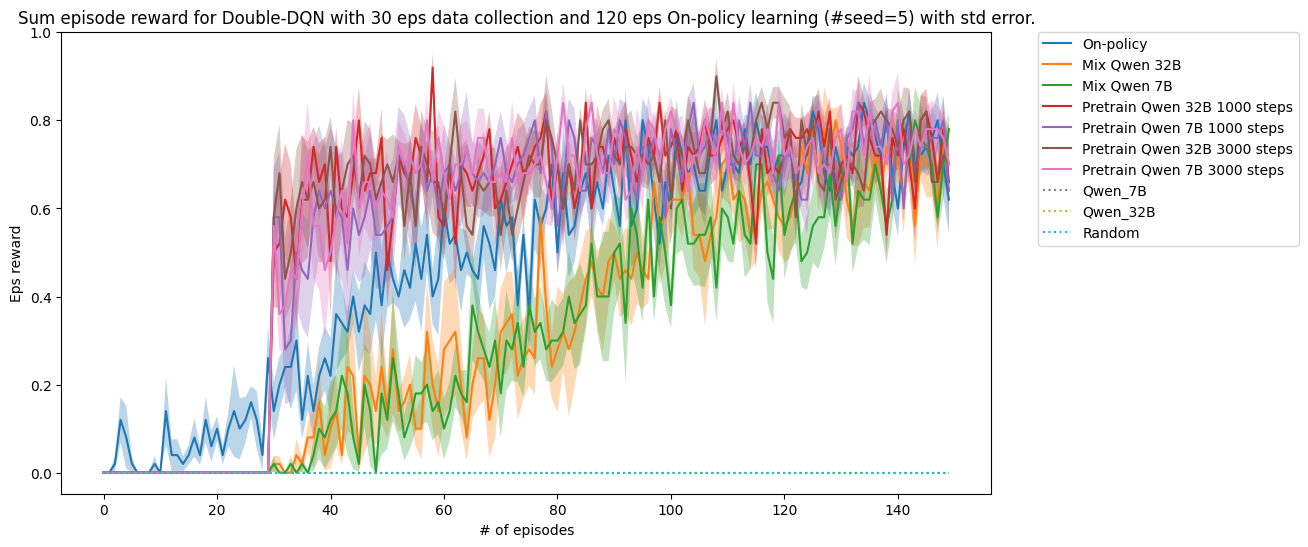

In [47]:
hyperparams["n_pretrain_eps"]=30
hyperparams["n_online_eps"]=150-hyperparams["n_pretrain_eps"]
with open(f"data/cache_{hyperparams['env'].split('-')[0]}_Neps_{hyperparams['n_pretrain_eps']}.pkl", 'rb') as file: #CartPoleE
# with open(f"data/cache_{hyperparams['env'].split('-')[0]}_Neps_{hyperparams['n_pretrain_eps']}_withEps.pkl", 'rb') as file: #CartPoleE
    cache30 = pickle.load(file)
out_dict30 = cache_to_arrays(cache30, mean_random, Qwen_7B, Qwen_32B)

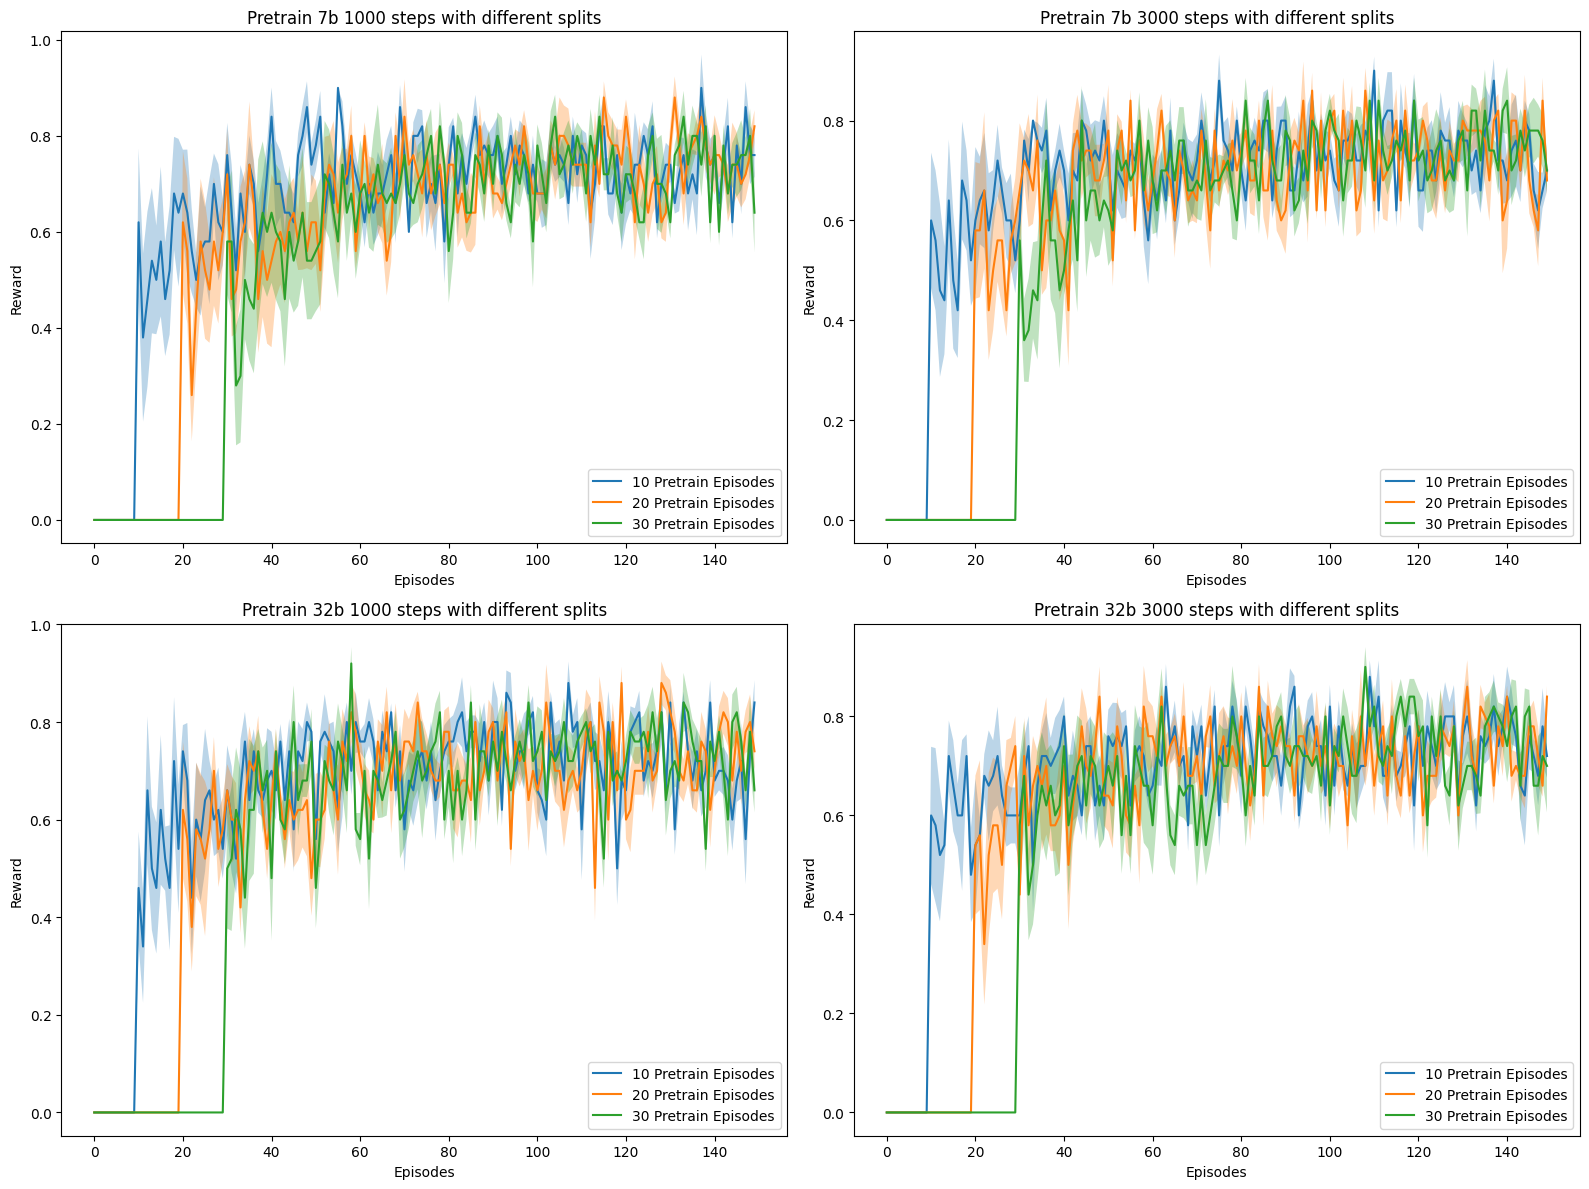

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
x = range(hyperparams["n_pretrain_eps"] + hyperparams["n_online_eps"])

def plot_mean_std(ax, x, dict_label, title):
    mean = out_dict10[f"mean_{dict_label}"]
    std = out_dict10[f"std_{dict_label}"]
    ax.plot(x, mean, label="10 Pretrain Episodes")
    ax.fill_between(x, mean - std/np.sqrt(hyperparams["n_exp"]), mean + std/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    mean = out_dict20[f"mean_{dict_label}"]
    std = out_dict20[f"std_{dict_label}"]
    ax.plot(x, mean, label="20 Pretrain Episodes")
    ax.fill_between(x, mean - std/np.sqrt(hyperparams["n_exp"]), mean + std/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    mean = out_dict30[f"mean_{dict_label}"]
    std = out_dict30[f"std_{dict_label}"]
    ax.plot(x, mean, label="30 Pretrain Episodes")
    ax.fill_between(x, mean - std/np.sqrt(hyperparams["n_exp"]), mean + std/np.sqrt(hyperparams["n_exp"]), alpha=0.3)
    ax.set_title(title)
    ax.set_xlabel("Episodes")
    ax.set_ylabel("Reward")
    ax.legend()

plot_mean_std(axs[0, 0], x, "pretrain_7b_1000", "Pretrain 7b 1000 steps with different splits")
plot_mean_std(axs[0, 1], x, "pretrain_7b_3000", "Pretrain 7b 3000 steps with different splits")
plot_mean_std(axs[1, 0], x, "pretrain_32b_1000", "Pretrain 32b 1000 steps with different splits")
plot_mean_std(axs[1, 1], x, "pretrain_32b_3000", "Pretrain 32b 3000 steps with different splits")
plt.tight_layout()
plt.show()